# 客户画像复赛 主程序

In [1]:
!ls Data_Update/train/

01_arc_s_95598_wkst_train.tsv  06_cont_info.tsv		11_c_meter.tsv
02_s_comm_rec.tsv	       07_c_rca_cons.tsv	12_a_pay_flow.tsv
03_s_info_oversee.tsv	       08_a_rcved_flow.tsv	out
04_c_cons.tsv		       09_arc_a_rcvbl_flow.tsv	train_label.csv
05_c_cons_prc.tsv	       10_c_meter_read.tsv


## 1 导入必要的包和函数

In [1]:
%pdb 1
debug = 1
import pandas as pd
import numpy as np
import pickle
import re
import io 
import matplotlib.pyplot as plt
%matplotlib inline

# 加载预定义好的函数
# 预定义好的函数：
#    - load_data(file_name, header=0): 加载数据
#    - def show_attribute_detail( data=None, attribute_name=None): 显示数据某个属性的详情
%run data_util_func.py
# 选择过滤方案
PLAN_TYPE = 3

Automatic pdb calling has been turned ON
RF_N_ESTIMATORS:100


#### 恢复ipython变量

In [49]:
# 训练集敏感用户 和待预测用户列表
# train_data_labels_df
# test_data_labels_df
# 01表
# train_data01_merge_label_df
# test_data01_merge_label_df
# 代表工单数据
# train_data01_a_worker_per_user
# test_data01_a_worker_per_user
# 08表
# train_data08_merge_label_df
# test_data08_merge_label_df
# 09表
# train_data09_merge_label_df
# test_data09_merge_label_df

%store -r train_data01_a_worker_per_user test_data01_a_worker_per_user

In [10]:
del train_data01_a_worker_per_user
del test_data01_a_worker_per_user

In [2]:
%who_ls

[u'test_data01_a_worker_per_user', u'train_data01_a_worker_per_user']

##  2 加载数据 

### 2-1 用户列表

#### 2-1-1 训练集

##### 2-1-1-1  加载敏感用户标签 train_label.csv

In [15]:
# 要特别注意 统一设置 converters={0:unicode}，
# 避免后面连接错误
train_data_labels_df = load_data(file_name = 'Data_Update/train/train_label.csv',
                                 header=None,
                                 converters={0:unicode}
                                )
print(train_data_labels_df.shape)

(80025, 1)


##### 2-1-1-2  增加敏感标签字段

In [16]:
# 增加敏感标签字段，都是敏感用户，全部标为1
train_data_labels_df.columns = ['CUST_NO']
train_data_labels_df['TAG'] = 1
show_df_info(train_data_labels_df)

      CUST_NO  TAG
0  6028082372    1
1  6025004210    1
2  4415361544    1
3  1658079044    1
4  1658079045    1
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 80025 entries, 0 to 80024
Data columns (total 2 columns):
CUST_NO    80025 non-null object
TAG        80025 non-null int64
dtypes: int64(1), object(1)
memory usage: 1.2+ MB
None


In [9]:
train_data_labels_df[train_data_labels_df['CUST_NO']=='1920004047']

,CUST_NO,TAG
424,1920004047,1


In [17]:
%store train_data_labels_df

Stored 'train_data_labels_df' (DataFrame)


#### 2-1-2 测试集 

##### 2-1-2-1  加载待预测用户标签 test_to_predict.csv

In [18]:
# 要特别注意 统一设置 converters={'CUST_NO':unicode}，
# 避免后面连接错误
test_data_labels_df = load_data(file_name = 'Data_Update/test/test_to_predict.csv',
                                header=None,
                                converters={0:unicode}
                               )

test_data_labels_df.columns = ['CUST_NO']
show_df_info(test_data_labels_df)

      CUST_NO
0  6010419435
1  6310918440
2  4716029245
3  6010936575
4  3318025855
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 370871 entries, 0 to 370870
Data columns (total 1 columns):
CUST_NO    370871 non-null object
dtypes: object(1)
memory usage: 2.8+ MB
None


In [19]:
%store test_data_labels_df

Stored 'test_data_labels_df' (DataFrame)


#### 2-1-3  小结
- 训练数据敏感用户标签有：80,025 个
- 测试数据待预测用户有  ：370,871 个

### 2-2 95598工单信息（包含训练集和测试集所有用户列表）

#### 2-2-1 训练集 

##### 2-2-1-1 加载数据 01_arc_s_95598_wkst_train.tsv

In [20]:
%%time
# 要特别注意 设置 converters={'CUST_NO':unicode}，
# 这个类型转换非常重要，因为发现在和 train_label.csv表 的 CUST_NO 连接时 ，如果不全部转为 字符串 ，会连接 不对，因为
# 在这个表里的 CUST_NO 字段出现 部分 字段是字符串，部分字段是整形，所以全部转为字符串
train_data01_df = load_data('Data_Update/train/01_arc_s_95598_wkst_train.tsv',converters={'CUST_NO':unicode}) 
# 记录数 1190198
print(train_data01_df.shape)
# 将客户编号提取并去重，发现只有 658,374个用户编号
len(set(train_data01_df['CUST_NO']))

(1190198, 13)
CPU times: user 4.68 s, sys: 460 ms, total: 5.14 s
Wall time: 5.85 s


##### 2-2-1-2 数据摘要

In [41]:
show_df_info(data=train_data01_df)

             APP_NO                ID  BUSI_TYPE_CODE  URBAN_RURAL_FLAG  \
0  2015101280016584  1000000527201688               1               2.0   
1  2015101280016722  1000000527203612               3               2.0   
2  2015101280016734  1000000527203685               3               2.0   
3  2015101280019989  1000000527220221               3               1.0   
4  2015101280020073  1000000527220797               3               1.0   

      ORG_NO         HANDLE_TIME  \
0    3340501  2015/10/12 7:27:08   
1    3341020  2015/10/12 7:31:50   
2    3340670  2015/10/12 7:32:03   
3    3340401  2015/10/12 8:04:42   
4  334010101  2015/10/12 8:06:05   

                                    ACCEPT_CONTENT HANDLE_OPINION  CALLING_NO  \
0  【一户无电】非居民客户报修一户无电，经指导客户检查，无法判断设备故障及其资产归属，请现场查处。            NaN   1625671.0   
1                                 【银行代扣】客户咨询银行代扣事宜            NaN   1196922.0   
2                            【查询电费】客户查询本月电费金额，已告知。            NaN   1378624.0   
3       

##### 2-2-1-3 将工单表和用户列表连接 ---> 为了 得到是否敏感的 标签 TAG):
- 训练集 - 加上标签信息(0-不敏感，1-敏感)

In [21]:
%%time
# 利用和 敏感用户 表连接 来获取标签
train_data01_merge_label_df = train_data01_df.merge(train_data_labels_df,on=u'CUST_NO',how='left')
# 将没有连接上的工单设置为不敏感用户
train_data01_merge_label_df['TAG'] = train_data01_merge_label_df['TAG'].fillna(0)
train_data01_merge_label_df['TAG'] = train_data01_merge_label_df['TAG'].astype(int)

CPU times: user 1.02 s, sys: 140 ms, total: 1.16 s
Wall time: 1.2 s


In [24]:
# 缓存
%store train_data01_merge_label_df

Stored 'train_data01_merge_label_df' (DataFrame)


In [16]:
len(train_data01_merge_label_df['CUST_NO'].unique()) == 658374

True

(2,)
CPU times: user 76 ms, sys: 4 ms, total: 80 ms
Wall time: 80 ms


0    895063
1    295135
Name: TAG, dtype: int64

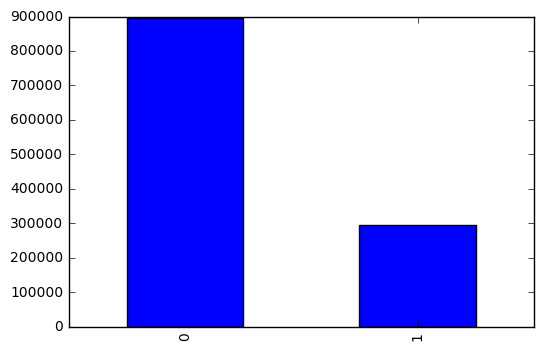

In [17]:
%%time
# 所有工单的统计
show_attribute_detail(train_data01_merge_label_df,u'TAG')

(2,)
CPU times: user 648 ms, sys: 340 ms, total: 988 ms
Wall time: 986 ms


0    578349
1     80025
Name: TAG, dtype: int64

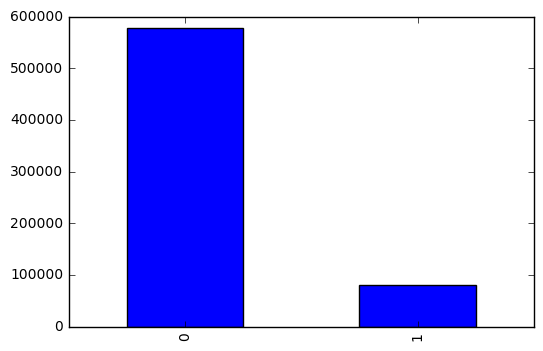

In [18]:
%%time
# 所有用户的统计
show_attribute_detail(train_data01_merge_label_df[['CUST_NO','TAG']].drop_duplicates(),u'TAG')

##### 2-3-1-4 保存 用户

###### 输出 训练集 中 敏感用户列表（sensitive.csv）和不敏感用户列表（nonsensitive.csv）

In [19]:
pd.DataFrame(
    data = {'CUST_NO':train_data01_merge_label_df.loc[train_data01_merge_label_df['TAG']==1,'CUST_NO'].unique()}
).to_csv('sensitive_users_list.csv',encoding='utf8',index=False)

pd.DataFrame(
    data = {'CUST_NO':train_data01_merge_label_df.loc[train_data01_merge_label_df['TAG']==0,'CUST_NO'].unique()}
).to_csv('nonsensitive_users_list.csv',encoding='utf8',index=False)

###### 输出 工单训练集中 所有用户和标签，共 658,374个用户

In [8]:
train_data01_cust_no_tag_df = \
    train_data01_merge_label_df[['CUST_NO','TAG']].drop_duplicates().sort_values(by='TAG')
save_data(
    train_data01_cust_no_tag_df,
    'train_data01_cust_no_tag_df.csv'
)
train_data01_cust_no_tag_df.shape

(658374, 2)

###### 从文件中恢复

In [5]:
# CONS_NO 全部转为字符串，否则在连接表的时候会出问题
train_data01_cust_no_tag_df = load_data('train_data01_cust_no_tag_df.csv',
                                        encoding='utf8',
                                        converters={'CUST_NO':unicode}
                                       )

#### 2-2-2 测试集 

##### 2-2-2-1 加载数据 01_arc_s_95598_wkst_test.tsv

In [22]:
%%time
# 要特别注意 设置 converters={'CUST_NO':unicode}，
# 这个类型转换非常重要，因为发现在和 train_label.csv表 的 CUST_NO 连接时 ，如果不全部转为 字符串 ，会连接 不对，因为
# 在这个表里的 CUST_NO 字段出现 部分 字段是字符串，部分字段是整形，所以全部转为字符串
test_data01_df = load_data('Data_Update/test/01_arc_s_95598_wkst_test.tsv',converters={'CUST_NO':unicode}) 
# 记录数 423,728
print(test_data01_df.shape)
# 将客户编号提取并去重，发现只有 370,871个用户编号
len(set(test_data01_df['CUST_NO']))

(423728, 13)
CPU times: user 1.87 s, sys: 88 ms, total: 1.96 s
Wall time: 2.17 s


##### 2-2-2-2 数据摘要

In [48]:
show_df_info(data=test_data01_df)

             APP_NO                ID  BUSI_TYPE_CODE  URBAN_RURAL_FLAG  \
0  2015101280019632  1000000527215943               3               1.0   
1  2015101280019648  1000000527216033              10               2.0   
2  2015101280019680  1000000527216202               3               2.0   
3  2015101280019873  1000000527218491               3               1.0   
4  2015101280020130  1000000527221199               1               1.0   

      ORG_NO         HANDLE_TIME  \
0    3340780  2015/10/12 7:58:04   
1  334066001  2015/10/12 7:58:26   
2    3340690  2015/10/12 7:58:52   
3    3340810  2015/10/12 8:02:53   
4    3340501  2015/10/12 8:07:10   

                                      ACCEPT_CONTENT HANDLE_OPINION  \
0   【客户咨询一户无电】建议先自行联系有资质电工排查是否为内部故障，客户接受并表示有其他情况再致电。            NaN   
1  【退订】#2061584501；【退订】#2061584602；【退订】#406091928...            NaN   
2                                【查询电费】客户查询本月电费，已告知。            NaN   
3                           【咨询总户号】通过地址、户名查询户号信息

##### 2-2-2-3 将工单表 和 待预测用户表连接

In [23]:
%%time
# 利用和 敏感用户 表连接 来获取标签
test_data01_merge_label_df = test_data01_df.merge(test_data_labels_df,on=u'CUST_NO',how='left')

CPU times: user 684 ms, sys: 28 ms, total: 712 ms
Wall time: 715 ms


In [25]:
%%time
# 缓存
%store test_data01_merge_label_df

Stored 'test_data01_merge_label_df' (DataFrame)
CPU times: user 1.53 s, sys: 144 ms, total: 1.68 s
Wall time: 1.69 s


In [23]:
len(test_data01_merge_label_df['CUST_NO'].unique()) == 370871

True

#### 2-2-3 小结：
- 训练集
    - 有：1,190,198（有658,374个用户）个工单数据,其中不敏感用户的工单有 895,063 （有578,349个用户），而敏感用户的工单有 295,135（有80,025个用户(占总数的0.1215)，跟train_label.csv中给一模一样）————> 看出 敏感用户 的平均工单数比 不敏感用户 高很多
    - 不敏感工单数： 895,063，敏感工单数：295,135，比例为 3.0327

- 测试集
    - 有：  423,728个工单数据
    - 将测试集客户编号提取并去重，发现测试集只有 370,871用户编号,跟 test_to_predict.csv 一样

## 3 进行不同特征的探索

- 01表 http://localhost:8888/notebooks/data_processing-01table.ipynb#客户画像复赛-数据处理---01表（工单信息）特征提取
- 04/05/10/11/12表 http://localhost:8888/notebooks/data_processing-04%2605%2611%2612table.ipynb#客户画像复赛-数据处理---04&05&10&11/12表特征提取
- 06/07表 http://localhost:8888/notebooks/data_processing-06%2607table.ipynb#客户画像复赛-数据处理---06&07表特征提取
- 08表 http://localhost:8888/notebooks/data_processing-08table.ipynb#客户画像复赛-数据处理---08表（实收电费信息表）特征提取
- 09表 http://localhost:8888/notebooks/data_processing-09table.ipynb#客户画像复赛-数据处理---09表（应收电费信息表）特征提取

------
## 4 数据缓存和恢复

### 4-1 保存

#### 4-1-1 训练集

#### data01

In [52]:
%%time
save_data(
    train_data01_a_worker_per_user,
    'train_data01_a_worker_per_user.csv',
)
print train_data01_a_worker_per_user.shape

(658374, 72)
CPU times: user 1min 15s, sys: 1.06 s, total: 1min 17s
Wall time: 1min 18s


In [7]:
train_data01_a_worker_per_user.columns

Index([                                  u'APP_NO',
                                             u'ID',
                                 u'BUSI_TYPE_CODE',
                               u'URBAN_RURAL_FLAG',
                                         u'ORG_NO',
                                    u'HANDLE_TIME',
                                 u'ACCEPT_CONTENT',
                                 u'HANDLE_OPINION',
                                     u'CALLING_NO',
                                      u'ELEC_TYPE',
                                        u'CUST_NO',
                                    u'PROV_ORG_NO',
                                    u'CITY_ORG_NO',
                                            u'TAG',
                                  u'NUM_OF_WORKER',
                            u'ACCEPT_CONTENT_TYPE',
                               u'IS_SEARCH_ACTION',
                           u'NUM_OF_SEARCH_ACTION',
                                    u'HANDLE_HOUR',
            

In [12]:
%%time
save_data(
    train_data_toclassify[
        [
            'CUST_NO','TAG','NUM_OF_WORKER','NUM_OF_SEARCH_ACTION','BUSI_TYPE_CODE',
            'ACCEPT_CONTENT_TYPE','ELEC_TYPE','URBAN_RURAL_FLAG','HANDLE_MONTH',
            'NUM_OF_IN_SEASON4','RCA_FLAG','CONT_TYPE',
            'AVERAGE_RCVBL_AMT','ORG_NO_9bit','NUM_OF_RCVBL_PENALTY',
            'MULTI_ACCEPT_CONTENT_TYPE','MONEY_PER_DEGREE_STD',
            'ORG_NO_100bit','IS_HEBIAO_USER','IS_SEPERATE_TIME','ELEC_DEGREE','IS_MID_CHANGE'
        ]
    ],
    'train_features_20161215.csv'
)
# print train_data01_a_worker_per_user.shape

CPU times: user 12.6 s, sys: 108 ms, total: 12.7 s
Wall time: 12.9 s


In [59]:
train_data01_a_worker_per_user['CITY_ORG_NO'].head()

0    33410
1    33409
2    33401
3    33402
4    33401
Name: CITY_ORG_NO, dtype: int64

In [50]:
train_data01_a_worker_per_user[train_data01_a_worker_per_user['MONEY_PER_DEGREE_STD']>10000]

14        1.797693e+308
101       1.797693e+308
793       1.797693e+308
796       1.797693e+308
1090      1.797693e+308
1149      1.797693e+308
1158      1.797693e+308
1249      1.797693e+308
1440      1.797693e+308
1442      1.797693e+308
2734      1.797693e+308
2810      1.797693e+308
3013      1.797693e+308
3263      1.797693e+308
3501      1.797693e+308
3722      1.797693e+308
3790      1.797693e+308
4025      1.797693e+308
5142      1.797693e+308
5342      1.797693e+308
5441      1.797693e+308
6308      1.797693e+308
6583      1.797693e+308
6756      1.797693e+308
6773      1.797693e+308
6795      1.797693e+308
7365      1.797693e+308
7975      1.797693e+308
8227      1.797693e+308
8304      1.797693e+308
              ...      
649829    1.797693e+308
649942    1.797693e+308
650058    1.797693e+308
650282    1.797693e+308
650290    1.797693e+308
650837    1.797693e+308
650872    1.797693e+308
650945    1.797693e+308
651147    1.797693e+308
651362    1.797693e+308
652039    1.7976

In [55]:
average_rcvbl_amt_mean = train_data01_a_worker_per_user['MONEY_PER_DEGREE_STD'].mean()
average_rcvbl_amt_std = train_data01_a_worker_per_user['MONEY_PER_DEGREE_STD'].std()

In [56]:
temp = (train_data01_a_worker_per_user['MONEY_PER_DEGREE_STD'] - average_rcvbl_amt_mean) / average_rcvbl_amt_std

In [57]:
average_rcvbl_amt_mean,average_rcvbl_amt_std

(inf, inf)

In [32]:
train_data01_a_worker_per_user.shape,test_data01_a_worker_per_user.shape

((658374, 68), (370871, 67))

In [20]:
%store train_data01_a_worker_per_user

Stored 'train_data01_a_worker_per_user' (DataFrame)


#### 4-1-2 测试集

#### data01

In [53]:
%%time
save_data(
    test_data01_a_worker_per_user,
    'test_data01_a_worker_per_user.csv'
)
print test_data01_a_worker_per_user.shape

(370871, 71)
CPU times: user 35.4 s, sys: 372 ms, total: 35.7 s
Wall time: 36 s


In [14]:
test_data01_a_worker_per_user.head()

,APP_NO,ID,BUSI_TYPE_CODE,URBAN_RURAL_FLAG,ORG_NO,HANDLE_TIME,ACCEPT_CONTENT,HANDLE_OPINION,CALLING_NO,ELEC_TYPE,...,LAST_MONTH_PAY_MODE_4bit,PAY_MODE_4bit_CHANGE_CLUE,MONEY_PER_DEGREE_STD,MULTI_ACCEPT_CONTENT_TYPE,ORG_NO_100bit,IS_HEBIAO_USER,IS_ELEC_EQ_ZERO,IS_SEPERATE_TIME,IS_MID_CHANGE,ELEC_DEGREE
0,2015101280019632,1000000527215943,3,1.0,3340780,2015/10/12 7:58:04,【客户咨询一户无电】建议先自行联系有资质电工排查是否为内部故障，客户接受并表示有其他情况再致电。,NaN,1628699.0,202.0,...,101.0,0203-0101,0.025006,客户咨询一户无电,3.340780e+08,0,False,1,0,1
1,2015101280019648,1000000527216033,10,2.0,334066001,2015/10/12 7:58:26,【退订】#2061584501；【退订】#2061584602；【退订】#406091928...,NaN,1260775.0,201.0,...,203.0,0203,0.000046,退订,3.340660e+10,0,False,0,0,1
2,2015101280019680,1000000527216202,3,2.0,3340690,2015/10/12 7:58:52,【查询电费】客户查询本月电费，已告知。,NaN,1536321.0,201.0,...,203.0,0203,0.024686,查询电费+回呼电话,3.340690e+10,0,False,0,0,2
3,2015101280019873,1000000527218491,3,1.0,3340810,2015/10/12 8:02:53,【咨询总户号】通过地址、户名查询户号信息，已告知,NaN,1576698.0,NaN,...,101.0,0101,0.167792,咨询总户号,3.340801e+10,0,False,1,0,1
4,2015101280020130,1000000527221199,1,1.0,3340501,2015/10/12 8:07:10,【设备故障】客户报修此处线路打火，请处理。客户只能提供此地址，烦请电话联系057486581...,NaN,1089990.0,201.0,...,NaN,NaN,0.000000,设备故障,NaN,0,NaN,0,0,0


In [21]:
%store test_data01_a_worker_per_user

Stored 'test_data01_a_worker_per_user' (DataFrame)


### 4-2 恢复

#### 4-2-1 训练集

#### data01

In [3]:
%%time
train_data01_a_worker_per_user = load_data('train_data01_a_worker_per_user.csv',
                                               encoding='utf8',
                                               converters={
                                                   'CUST_NO': unicode,
                                                   'LAST_MONTH_PAY_MODE': unicode,
                                               })
print train_data01_a_worker_per_user.shape

/usr/local/lib/python2.7/dist-packages/IPython/core/magic.py:188: DtypeWarning: Columns (54) have mixed types. Specify dtype option on import or set low_memory=False.
  call = lambda f, *a, **k: f(*a, **k)


(658374, 66)
CPU times: user 12.4 s, sys: 1.18 s, total: 13.5 s
Wall time: 14.3 s


In [37]:
train_data01_a_worker_per_user.head()

,APP_NO,ID,BUSI_TYPE_CODE,URBAN_RURAL_FLAG,ORG_NO,HANDLE_TIME,ACCEPT_CONTENT,HANDLE_OPINION,CALLING_NO,ELEC_TYPE,...,IS_PAY_MODE_CONTAINS_020261,LAST_MONTH_PAY_MODE,PAY_MODE_CHANGE_CLUE,CUST_NO_3bit,ORG_NO_9bit,LAST_MONTH_PAY_MODE_4bit,PAY_MODE_4bit_CHANGE_CLUE,MONEY_PER_DEGREE_STD,MULTI_ACCEPT_CONTENT_TYPE,ORG_NO_100bit
2,2015101280031424,1000000527305097,3,2.0,33401,2015/10/12 9:14:16,【查询电费】客户查询电费，已告知。,NaN,1007513.0,405.0,...,0.0,020271,020271,601,334010103,0202,0202,0.003929,查询电费+电力短信,334010103
7,2015101280020177,1000000527221507,3,1.0,3340201,2015/10/12 8:07:49,【停电信息】咨询计划停电信息,NaN,1468213.0,403.0,...,0.0,020311,020311,161,334020106,0203,0203,0.003810,停电信息,33402010608
8,2015101280020305,1000000527223326,10,1.0,334063001,2015/10/12 8:09:35,【查询电费】客户查询电费，已告知。【新增订阅】#电费#短信#2015-10-12#2016-...,NaN,1263913.0,202.0,...,0.0,020311,020311,703,334063001,0203,0203,0.022373,查询电费,33406300120
11,2015101280032546,1000000527305940,3,1.0,334034001,2015/10/12 9:15:05,【分时电价】客户咨询是否已开通分时电价/分时电价政策/分时电价开通范围及条件,NaN,1698477.0,202.0,...,0.0,020311,010101-020311,172,334034001,0203,0101-0203,0.043483,分时电价,334034001
13,2015101280032782,1000000527308505,3,2.0,334050103,2015/10/12 9:16:57,【查询电费】客户查询电费，已告知。,NaN,1096836.0,202.0,...,0.0,010101,010101,500,334050103,0101,0101,0.000014,服务渠道+查询电费,33405010303


#### 4-2-2 测试集

#### data01

In [4]:
%%time
test_data01_a_worker_per_user = load_data('test_data01_a_worker_per_user.csv',
                                              encoding='utf8',
                                              converters={
                                                  'CUST_NO': unicode,
                                                  'LAST_MONTH_PAY_MODE': unicode,
                                              }
                                         )
print test_data01_a_worker_per_user.shape

(370871, 65)
CPU times: user 5.48 s, sys: 364 ms, total: 5.84 s
Wall time: 6.17 s


## 5 准备数据和模型构建  ---> 这部分 转到 kfold_validation.py 脚本中执行

### 5-1 数据细分
    - 规则匹配 - 根据 工单内容 的类型不敏感度 过滤掉 部分不敏感 用户 ,或者直接判定部分用户为 敏感用户等
    - 交于分类器处理

#### 5-1-1 训练集

In [31]:
train_data_toclassify, train_data_sensitive = seperate_data_to_classifier(
    train_data01_a_worker_per_user,
    plan_type=PLAN_TYPE
)

total: 658374
is_connect_to_09table == 1 : 555748
is_connect_to_09table == 0 : 102626
剩下: 555748(敏感：80025,不敏感：475723，比例：5.944680)
根据 用电类别 ELEC_TYPE 进行过滤
ELEC_TYPE_IS_NONSENSITIVE: 6(敏感：0,不敏感：6)
剩下: 555742
剩下: 555742(敏感：80025,不敏感：475717，比例：5.944605)
CONS_STATUS==3: 12 ——> 规则直接判为非敏感(敏感：0,不敏感：12)
CONT_TYPE==2: 28 ——> 规则直接判为非敏感(敏感：1,不敏感：27)
剩下: 555702(敏感：80024,不敏感：475678，比例：5.944192)
data_connect_to_09table 进一步根据total和tag1/total过滤...
tag1/total == 1 ——> 规则直接判为敏感: 122(敏感：122,不敏感：0)
tag1/total < 0.01 ——> 规则直接判为非敏感: 174472(敏感：436,不敏感：174036)
剩下: 380542(敏感：79395,不敏感：301147，比例：3.793022)


In [5]:
save_data(
        train_data_toclassify[['CUST_NO','TAG']],
        'data_to_classify_true_tag.csv',
    )

(2,)


0    262531
1     77574
Name: TAG, dtype: int64

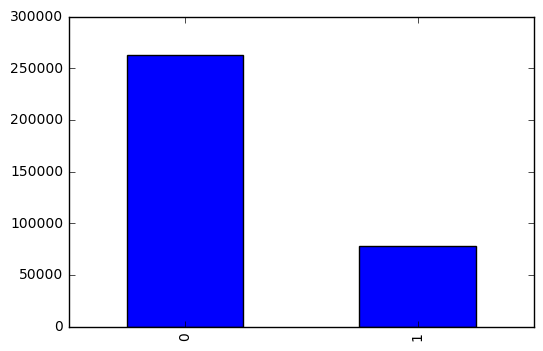

In [53]:
show_attribute_detail(
    train_data_toclassify,
    attribute_name='TAG', 
)

#### 5-1-2 测试集

In [36]:
test_data_toclassify, test_data_sensitive = seperate_data_to_classifier(
    test_data01_a_worker_per_user,
    type='test',
    plan_type=PLAN_TYPE
)

total: 370871
is_connect_to_09table == 1 : 201702
is_connect_to_09table == 0 : 169169
剩下: 201702
根据 用电类别 ELEC_TYPE 进行过滤
ELEC_TYPE_IS_NONSENSITIVE: 3
剩下: 201699
剩下: 201699
CONS_STATUS==3: 1 ——> 规则直接判为非敏感
CONT_TYPE==2: 13 ——> 规则直接判为非敏感
剩下: 201685
data_connect_to_09table 进一步根据total和tag1/total过滤...
tag1/total == 1 ——> 规则直接判为敏感: 9
tag1/total < 0.01 ——> 规则直接判为非敏感: 85823
剩下: 115500


#### 5-1-3 小结
- 目前总共使用了两个版本的过滤规则，详细看 (含线下F值计算)train&test_accept_content_type.xlsx

### 5-2 特征编码

#### 5-2-1 训练集

In [22]:
%%time
train_data_features = data_feature_encoder.fit_transform(
    train_data_toclassify,
)
print train_data_features.shape

工单数 1
查询电费次数 1
第四季度记录数 1
应收违约金的次数 1
平均电费 1
是否连接上06表 1
是否连接上07表 1
是否连接上08表 1
是否连接上09表 1
是否违约 1
是否违约超出1个月以上 1
代表工单月份 1
城乡标志 3
用电类型 12
小工单类型 169
CONT_TYPE 1
STATUS 2
CONS_STATUS 2
RCA_FLAG 2
ORG_NO_7bit_09TABLE 59
(340098, 262)
CPU times: user 5.74 s, sys: 7.61 s, total: 13.4 s
Wall time: 16.5 s


In [3]:
train_data_features.head()

NameError: name 'train_data_features' is not defined

> <ipython-input-3-09d1fbab48f5>(1)<module>()
----> 1 train_data_features.head()

ipdb> q


#### 5-2-2 测试集

In [27]:
%%time
test_data_features = data_feature_encoder.transform(
    test_data_toclassify,
)

工单数 1
查询电费次数 1
第四季度记录数 1
应收违约金的次数 1
平均电费 1
是否连接上06表 1
是否连接上07表 1
是否连接上08表 1
是否连接上09表 1
是否违约 1
是否违约超出1个月以上 1
代表工单月份 1
城乡标志 3
用电类型 12
小工单类型 169
CONT_TYPE 1
STATUS 2
CONS_STATUS 2
RCA_FLAG 2
ORG_NO_7bit_09TABLE 59
CPU times: user 3.09 s, sys: 2.8 s, total: 5.89 s
Wall time: 9.18 s


In [16]:
test_data_features.head()

,NUM_OF_WORKER,URBAN_RURAL_FLAG_1.0,URBAN_RURAL_FLAG_2.0,URBAN_RURAL_FLAG_3.0,ELEC_TYPE_100.0,ELEC_TYPE_200.0,ELEC_TYPE_201.0,ELEC_TYPE_202.0,ELEC_TYPE_203.0,ELEC_TYPE_300.0,...,ACCEPT_CONTENT_TYPE_电费账单寄送,ACCEPT_CONTENT_TYPE_电量异常,ACCEPT_CONTENT_TYPE_短信变更,ACCEPT_CONTENT_TYPE_短信订阅,ACCEPT_CONTENT_TYPE_缴费方式,ACCEPT_CONTENT_TYPE_补充信息,ACCEPT_CONTENT_TYPE_表箱故障,ACCEPT_CONTENT_TYPE_表计信息,ACCEPT_CONTENT_TYPE_阶梯电价,ACCEPT_CONTENT_TYPE_验表
2,2,0,1,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6,1,0,1,0,0,0,1,0,0,0,...,0,0,0,0,1,0,0,0,0,0
7,1,1,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9,1,0,1,0,0,0,1,0,0,0,...,0,0,0,0,0,0,1,0,0,0
10,2,1,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0


### 5-3 模型分类